In [1]:
import numpy as np
import mitsuba as mi
import pandas as pd
import random

In [2]:
nm_per_ev_constant = (float(6.6260715e-34)*float(3.00e8)*float(1e9))/(float(1.6021e-19)*float(1e6))

In [3]:
#Values for linear interpolation.
wavelength_steps = [100, 200, 230, 270, 300, 330, 370, 400, 430, 470, 500, 530, 570, 600, 630, 670, 700, 1000]
qe_steps = [0, 0, 0.02, 0.20, 0.31, 0.35, 0.35, 0.33, 0.31, 0.24, 0.18, 0.08, 0.05, 0.02, 0.01, 0.002, 0, 0]
rows_to_drop =[]

#load data from original G4 output (csv format)
column_names = ["time (ps)", "x", "y", "z", "px", "py", "pz", "E (MeV)"]
photon_data_full = pd.read_csv('../Single_Emitter/photons_with_wavelength.csv', names = column_names,nrows=100)
initial_number_of_photons = photon_data_full.count()[0]
print(initial_number_of_photons)

def ev_to_nm (energy):
    return nm_per_ev_constant/energy

#gives linear relation between two wavelegths thanks to two efficiency values
def linear_interp (j,w_input):
    a = (qe_steps[j] - qe_steps[j-1])/(wavelength_steps[j] - wavelength_steps[j-1])
    b = qe_steps[j-1] - a*wavelength_steps[j-1]
    return a*w_input+b

#Convert energy column to wavelength in nm.
photon_data_full['E (MeV)'] = photon_data_full['E (MeV)'].apply(ev_to_nm)
photon_data_full.rename(columns={"E (MeV)": "Wavelength (nm)"}, inplace = True)

#iterate over each photon.
for i in range(initial_number_of_photons):
    for j in range(len(wavelength_steps)):
        #find index in wavelength_steps corresponding to the photon.
        if photon_data_full.loc[i, 'Wavelength (nm)']<wavelength_steps[j]:
            break
    #Use linear interpolation to calculate QE at this wavelength.
    qe_estimated = linear_interp(j, photon_data_full.loc[i, 'Wavelength (nm)']) 
    x = random.uniform(0, 1)
    if x > qe_estimated:
        rows_to_drop.append(i)

#generate new frame only with photons that will be detected.
photon_detected = photon_data_full.drop(rows_to_drop)
#I don't know why a first column is created and keeps track of the old index of photons.
photon_detected.reset_index(drop=True, inplace= True)

#Can be removed later. Outputs characteristics of saved photons.
photon_detected.to_csv('./photons_detected_spectral.csv' )
final_number_of_photons = photon_detected.count()[0]
fraction_detected = final_number_of_photons/initial_number_of_photons
print ("{0:.4} of emitted photon in G4 are actually detected.".format(fraction_detected))

100
0.09 of emitted photon in G4 are actually detected.


/tmp/ipykernel_97096/2793481962.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_number_of_photons = photon_data_full.count()[0]
/tmp/ipykernel_97096/2793481962.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_number_of_photons = photon_detected.count()[0]


In [4]:
x_position = photon_detected.values[:,1] # x position of the detector
y_position = photon_detected.values[:,2] # y position of the detectore
z_position = photon_detected.values[:,3] # z position of the detector
x_momentum = photon_detected.values[:,4] # x momentum of the particle
y_momentum = photon_detected.values[:,5] # y momentum of the particle
z_momentum = photon_detected.values[:,6] # z momentum of the particle
print(len(x_position))

# calculate the target coordinates for each photons
x_target = []
y_target = []
z_target = []
for i in range(len(x_position)):
    x_target.append(x_position[i] + x_momentum[i])
    y_target.append(y_position[i] + y_momentum[i])
    z_target.append(z_position[i] + z_momentum[i])


9


In [5]:
with open("photons_geometry.txt",'w')as f:
    f.write(f"{len(x_position)}\n")
    for x1,y1,z1,x2,y2,z2 in zip(x_position,y_position,z_position,x_target,y_target,z_target):
        f.write(f"{x1},{z1},{y1}\n")
        f.write(f"{x2},{z2},{y2}\n")        

In [6]:
photon_info = []
photon_info.append(len(x_position))
for x1,y1,z1,x2,y2,z2 in zip(x_position,y_position,z_position,x_target,y_target,z_target):
    photon_info.append(x1)
    photon_info.append(y1)
    photon_info.append(z1)
    photon_info.append(x2)
    photon_info.append(y2)
    photon_info.append(z2)

In [7]:
mi.set_variant('llvm_ad_rgb')
# Determine the size of the 3D array
size = (1, 1, len(photon_info))

# Create the 3D array filled with zeros
result = np.zeros(size, dtype=np.float32)

# Fill the first element of the 3D array with the values from the input array
result[0, 0, :] = photon_info
photon_list = mi.VolumeGrid(result)

print(photon_list)
print(result)
print(np.array(photon_list))

VolumeGrid[
  size = [55, 1, 1],
  channels = 1,
  max = 1191.52,
  max_channels = [
    1191.52, 
  ],
  data = [ 220 B of volume data ]
]
[[[ 9.00000000e+00 -1.13022000e-01  1.08496002e+02  1.08557996e+03
   -1.33006006e-01  1.08642853e+02  1.08656897e+03 -1.40441999e-01
    1.14511002e+02  1.14579004e+03 -1.44500330e-01  1.14661942e+02
    1.14677856e+03 -1.02063999e-01  1.06092003e+02  1.06152002e+03
   -9.06959996e-02  1.06241035e+02  1.06250879e+03 -1.60648003e-01
    1.18944000e+02  1.19017004e+03 -1.98531598e-01  1.19008629e+02
    1.19116724e+03 -8.46522003e-02  1.02272003e+02  1.02328003e+03
   -1.03739902e-01  1.02324005e+02  1.02427844e+03 -9.26797017e-02
    1.04032997e+02  1.04091003e+03 -6.80764988e-02  1.04176384e+02
    1.04189941e+03 -1.08372003e-01  1.07475998e+02  1.07537000e+03
   -1.33239001e-01  1.07530731e+02  1.07636816e+03 -8.47503990e-02
    1.02293999e+02  1.02348999e+03 -3.57073992e-02  1.02380371e+02
    1.02448511e+03 -1.60806999e-01  1.18978996e+02  1.19

In [8]:
import mitsuba as mi
import drjit as dr

mi.set_variant('llvm_ad_rgb')
scene_description =  {
    'type': 'scene',
    'sphere': {
        'type': 'sphere'
    },
    'spot1': {
        'type': 'spot',
        'to_world': mi.scalar_rgb.Transform4f.translate([0, 1, 0])
    },
    'spot2': {
        'type': 'spot',
        'to_world': mi.scalar_rgb.Transform4f.translate([0, 0, 1])
    },
    'integrator': {
        'type': 'ptracer',
    },
    'sensor': {
        'type': 'perspective',
    },
    'photon1':{
        'type': 'photon_emitter_old',
        'filename':'../Rich_Geometry/photon_geometry.bin',
        # 'photon_list': photon_list
    }
}

scene = mi.load_dict(scene_description)

render_image = mi.render(scene)

print(render_image)


TensorXf(shape=(576, 768, 3))


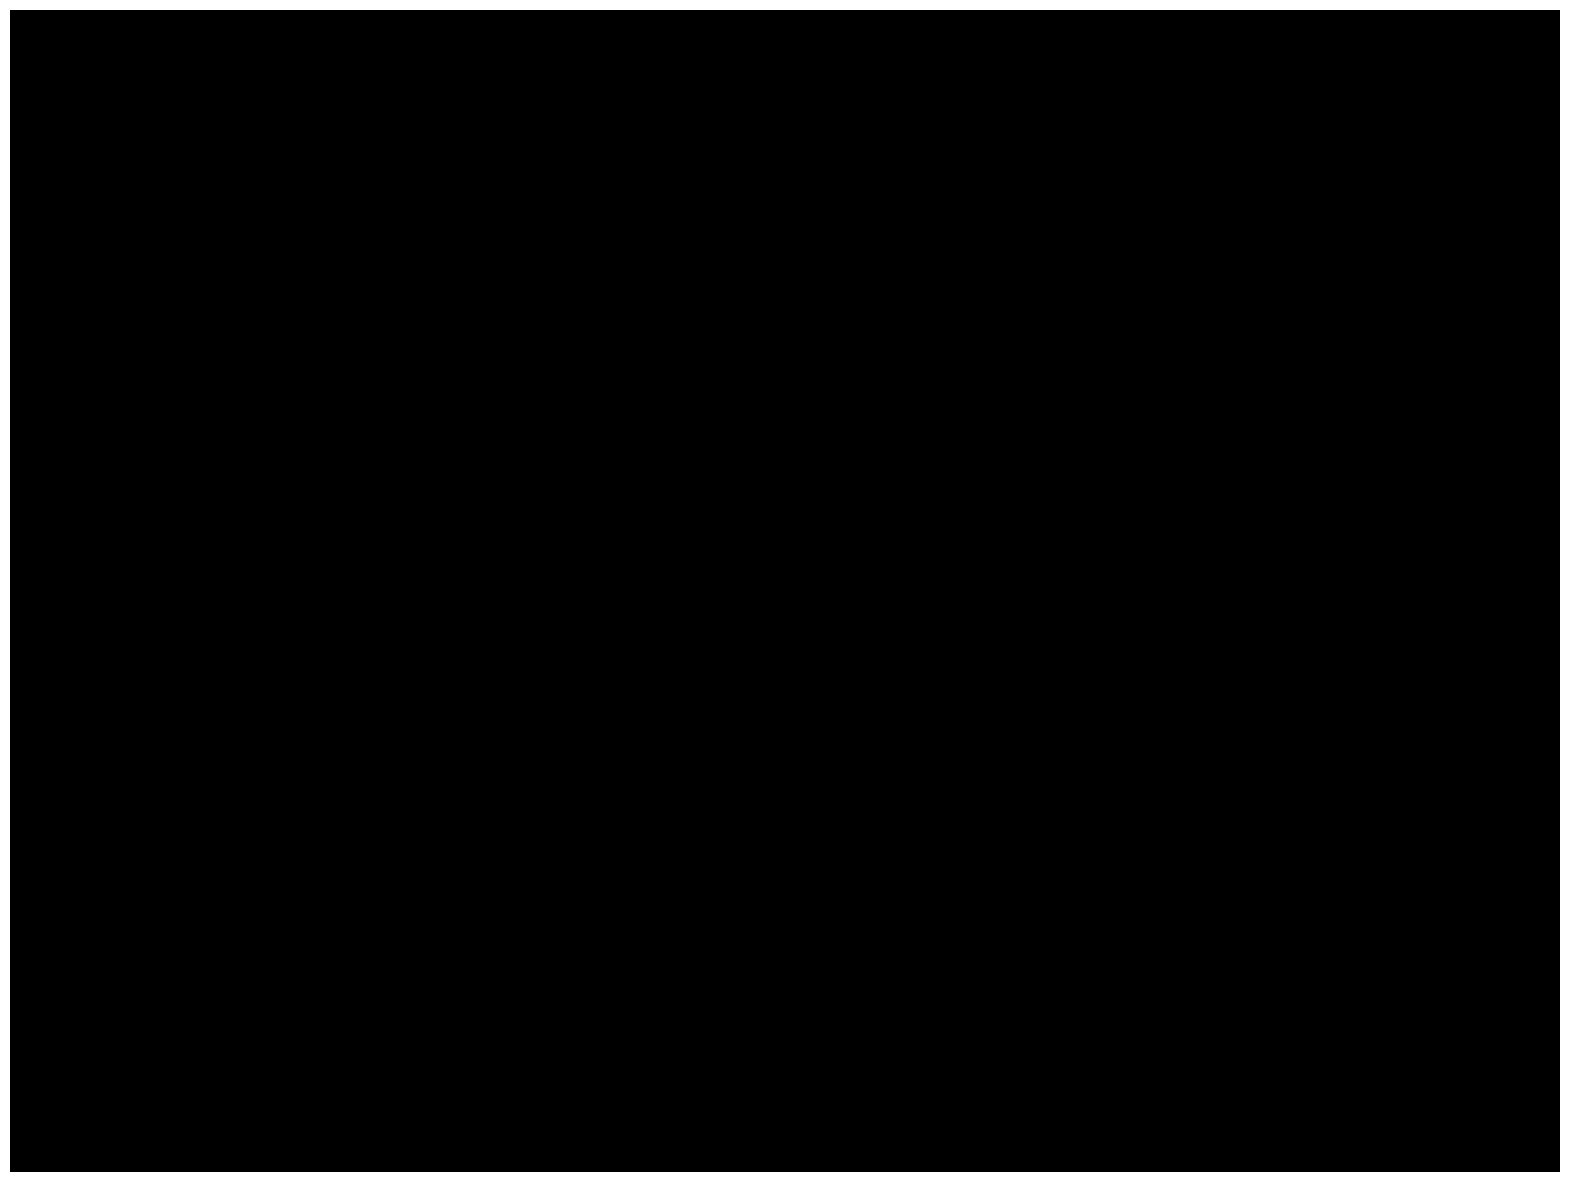

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(render_image ** (1.0 / 2.2)); 
plt.savefig('render_image')